# AAM_other_area.ipynb

- This notebook reproduces Figure 8 and Supplementary Figure S1a in Guo et al. (2025).
- **Additional data reminder**:
    - Pre-calculated data have been saved in `/data/processed/demo_data` and `/data/processed/weather_tabel_self/AAM_other_area/`, so figures in this notebook can be reproduced without additional datasets.
    - If desired, pre-calculated data can be reproduced using:
        - ERA5 IVT (2001–2019): calculate with `/src/main/data_processing/cal_ERA5_IVT.py`, with U, V, Q  downloaded from (https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=download)
        - IMERG (2001–2019): calculate with `src/main/data_processing/cal_IMERG_daily.py`, with hourly-data downloaded from (https://disc.gsfc.nasa.gov/)
- Execution order of cell sections for reproducing figures: 
    1. `Import`
    2. `Utilities`
    3. Each `Figure: ...`

# Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from datetime import datetime, timedelta
import logging
from functools import partial
import multiprocessing

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import seaborn.colors.xkcd_rgb as c
from matplotlib.gridspec import GridSpec

In [3]:
# --- self define modules --- #
import importlib
import sys
sys.path.append('../../src/main/')
import util_draw_polar
importlib.reload(util_draw_polar)

<module 'util_draw_polar' from '/data/ch995334/Multiscale-MoistDyn-Control/notebooks/main/../../src/main/util_draw_polar.py'>

# Utilities

## Data

In [4]:
topo_fpath = '../../data/raw/vvm_TOPO.nc'   # high-resolution (500m) Taiwan topography

In [7]:
aam_pcp_mean = np.load('../../data/processed/demo_data/AAM_avg_daily_pcp_summer.npy', allow_pickle=True).item()

In [8]:
global_z = xr.open_dataset('../../data/raw/ERA5Land_surf_geopotential.nc')
AAM_z    = global_z.z.sel(longitude=slice(66, 155), latitude=slice(30, -15)).isel(time=0)
AAM_topo = AAM_z/9.8

In [9]:
ds_lsm = xr.open_dataset('../../data/raw/IMERG_land_sea_mask.nc').sel(lon=slice(66, 156), lat=slice(-15, 30))
da_lsm = ds_lsm.landseamask
arr_lsm= da_lsm.values

In [10]:
wtab_all   = pd.read_csv(f"../../data/processed/weather_table_self/all_withlv.csv")       # weather table
datelist   = wtab_all['yyyymmdd']

In [11]:
gpm_temp   = xr.open_dataset("../../data/processed/demo_data/AAM_IMERG_daily_20010701.nc")
mask_empty = np.zeros(gpm_temp.daily_precip.shape)

## General classes and functions

### Plot tools

In [12]:
class PlotTools_cartopy():
    def __init__(self):
        self.proj = ccrs.PlateCarree()
    
    def Axe_map(self, fig, gs, 
                xlim_, ylim_, **grid_info):
        # Set map extent
        axe  = fig.add_subplot(gs, projection=self.proj)
        axe.set_extent([xlim_[0], xlim_[-1], ylim_[0], ylim_[-1]], crs=self.proj)
        # Set additional grid information
        if len(grid_info)>0:
            if grid_info['xloc_'] is not None:
                axe.set_xticks(grid_info['xloc_'], crs=self.proj)
                axe.set_xticklabels(['' for i in range(len(grid_info['xloc_']))])  # default: no tick labels
            if grid_info['yloc_'] is not None:
                axe.set_yticks(grid_info['yloc_'], crs=self.proj)
                axe.set_yticklabels(['' for i in range(len(grid_info['yloc_']))])
            gl = axe.gridlines(xlocs=grid_info['xloc_'], ylocs=grid_info['yloc_'], 
                               draw_labels=False)
        return axe
    
    def Plot_cartopy_map(self, axe):
        axe.add_feature(cfeature.LAND,color='grey',alpha=0.1)
        axe.coastlines(resolution='50m', color='black', linewidth=1)
    
plottools_ctpy = PlotTools_cartopy()

In [13]:
class PlotTools_vvm():
    def __init__(self):
        self.ds_topo = xr.open_dataset(topo_fpath)
        
    def Plot_vvm_map(self, axe, color, linewidth):
        axe.contour(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO, 
                    levels=np.array([-1e-3, 1e-3]), 
                    colors=color, linewidths=linewidth)
    
    def Plot_vvm_topo(self, axe, color, linewidth=None):
        topo_bounds= np.arange(0, 3500.1, 500)
        alpha_list = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        cmap_topo  = colors.ListedColormap([(0, 0, 0, i) for i in alpha_list])
        norm_      = colors.BoundaryNorm(topo_bounds, cmap_topo.N, extend='max')
        imtopoh    = axe.contourf(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO*1e2, 
                                  levels=topo_bounds, 
                                  cmap=cmap_topo, norm=norm_, extend='max', antialiased=1)
        if linewidth is not None:
            axe.contour(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO*1e2, levels=np.array([499.99, 500.01]), 
                        colors=color, linewidths=linewidth)
        else:
            pass
        return imtopoh
plottools_vvm = PlotTools_vvm()

In [14]:
def Plot_scatter(axe, x_, y_, c_=None, color_=None, 
                 s_=None, alpha_=None, label_=None, 
                 cmap_=None, bounds_=None, norm_=None, extend_='neither'):
    """
    Create scatter plot with some personal settings.
    """
    if bounds_ is not None:
        norm_    = colors.BoundaryNorm(bounds_, cmap_.N, extend=extend_)
    im = axe.scatter(x_, y_, c=c_, color=color_, s=s_, alpha=alpha_, 
                     label=label_, cmap=cmap_, norm=norm_)
    return im

### Figure info. settings

In [15]:
def draw_cat_bound(axe):
    axe.hlines(y=2, xmin=-6, xmax=-3.89, linewidths=5, colors='k')
    axe.hlines(y=0, xmin=-4.08, xmax=6, linewidths=5, colors='k')
    axe.vlines(x=-4, ymin=-0.12, ymax=2.12, linewidths=5, colors='k')
    axe.vlines(x=-2, ymin=-6, ymax=0, linewidths=5, colors='k')

In [16]:
sum_rgime_list    = ['N4', 'C6',  'B8',  'B9',  'B10', 'B11', 
                     'C4', 'C5',  'B4',  'B5',  'B6',  'B7', 
                     'C2', 'C3',  'B1',  'B2',  'B3',  'N3', 
                     'C1', 'A12', 'A13', 'A14', 'A15', 'N2', 
                     'A6', 'A7',  'A8',  'A9',  'A10', 'A11',
                     'A1', 'A2',  'A3',  'A4',  'A5',  'N1']

# Figure S1a: IMERG precip. over Taiwan

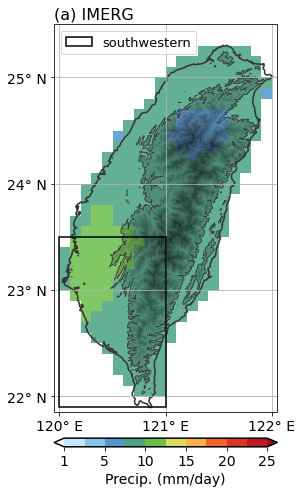

In [17]:
fig = plt.figure(figsize=(4, 8))
gs  = GridSpec(1, 1, figure=fig)
ax  = plottools_ctpy.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5], 
                             xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
plottools_vvm.Plot_vvm_map(ax, c['dark grey'], 1.5)  # coastline
# Precipitation
arr_pcp= np.where((arr_lsm<=70)&(aam_pcp_mean['mean']>0), aam_pcp_mean['mean'], np.nan)

bounds = [1]+np.arange(2.5, 25.1, 2.5).tolist()
cmap   = cmaps.WhiteBlueGreenYellowRed.copy()
cmap.set_under('w')
norm   = colors.BoundaryNorm(bounds, cmap.N, extend='both')
im_aampcp = ax.pcolormesh(np.arange(66, 156.1, 0.1), np.arange(-15, 30.1, 0.1), arr_pcp, cmap=cmap, norm=norm, alpha=0.85)
cax1  = fig.add_axes([ax.get_position().x0, ax.get_position().y0-0.06, ax.get_position().width, 0.015])
cbar1 = fig.colorbar(im_aampcp, orientation='horizontal', cax=cax1)
cbar1.solids.set(alpha=1)
cbar1.set_ticks(ticks=bounds[::2], labels=[int(i) for i in bounds[::2]])
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Precip. (mm/day)', fontsize=14)
cbar1.outline.set_linewidth(1.5)
# Topography
topo_bounds= np.arange(0, 3500.1, 500)
imtopoh    = plottools_vvm.Plot_vvm_topo(ax, c['dark grey'], 0.5)
# SW Taiwan
rect = patches.Rectangle((120, 21.9), 1, 1.6, fc="none", ec=c['black'], linewidth=1.5, zorder=50, label='southwestern')
ax.add_artist(rect)
ax.legend(handles=[rect], fontsize=13, loc='upper left')
# Other settings
ax.set_title('(a) IMERG', fontsize=16, loc='left')
ax.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=14)
ax.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=14) 
plt.show()

# Figure 8a: AAM summer mean precip. map

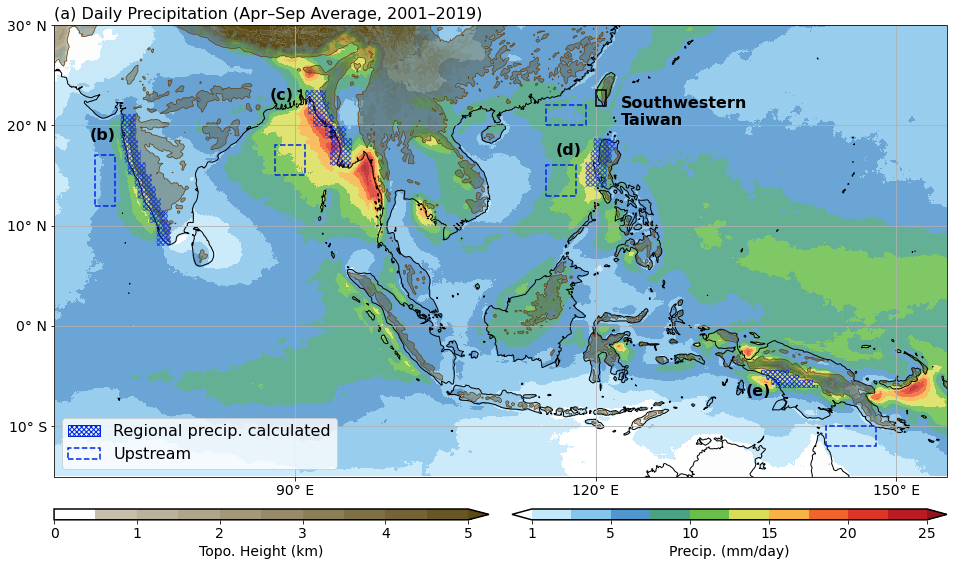

In [18]:
fig = plt.figure(figsize=(16, 10))
gs  = GridSpec(1, 1, figure=fig)
ax  = plottools_ctpy.Axe_map(fig, gs[0], xlim_=[65.95, 155.05], ylim_=[-15.05, 30], 
                             xloc_=np.arange(90, 160.1, 30), yloc_=np.arange(-10, 30.1, 10))
plottools_ctpy.Plot_cartopy_map(ax)

# Mask of India Ghats
mask_india = mask_empty.copy()
mask_india = mask_empty.copy()
mask_india[387:411, 126:141] = 1
mask_india[375:387, 127:143] = 1
mask_india[363:375, 130:146] = 1
mask_india[351:363, 133:151] = 1
mask_india[339:351, 140:157] = 1
mask_india[327:339, 143:161] = 1
mask_india[315:327, 148:166] = 1
mask_india[303:315, 155:173] = 1
mask_india[280:303, 162:176] = 1

# Mask of BoB
mask_bob   = mask_empty.copy()
mask_bob[423:435, 310:331] = 1
mask_bob[411:423, 313:334] = 1
mask_bob[399:411, 318:339] = 1
mask_bob[387:399, 330:351] = 1
mask_bob[375:387, 336:357] = 1
mask_bob[360:375, 335:356] = 1

# Mask of Luzon
mask_luzon = mask_empty.copy()
mask_luzon[375:387, 598:619] = 1
mask_luzon[363:375, 595:616] = 1
mask_luzon[339:363, 590:611] = 1

# Mask of New Guinea
mask_ngn   = mask_empty.copy()
mask_ngn[151:156, 765:793] = 1
mask_ngn[146:151, 770:803] = 1
mask_ngn[141:146, 775:817] = 1
mask_ngn[138:141, 780:822] = 1

mask_total = mask_india+mask_bob+mask_luzon+mask_ngn
# Mask hatch
none_cmap = colors.ListedColormap(['none'])
ax.pcolor(gpm_temp.lon, gpm_temp.lat, np.where(mask_total<1, np.nan, mask_total), shading='nearest', hatch='xxxxx', 
          cmap=none_cmap, edgecolor='#0025E0', lw=0, zorder=20)
# Precipitation
bounds = [1]+np.arange(2.5, 25.1, 2.5).tolist()
cmap   = cmaps.WhiteBlueGreenYellowRed.copy()
cmap.set_under('w')
norm   = colors.BoundaryNorm(bounds, cmap.N, extend='both')
im_aampcp = ax.pcolormesh(np.arange(66, 156.1, 0.1), np.arange(-15, 30.1, 0.1), aam_pcp_mean['mean'], cmap=cmap, norm=norm, alpha=0.85)
cax1  = fig.add_axes([ax.get_position().x0+ax.get_position().width/2+0.01, ax.get_position().y0-0.06, ax.get_position().width/2-0.01, 0.015])
cbar1 = fig.colorbar(im_aampcp, orientation='horizontal', cax=cax1)
cbar1.solids.set(alpha=1)
cbar1.set_ticks(ticks=bounds[::2], labels=[int(i) for i in bounds[::2]])
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Precip. (mm/day)', fontsize=14)
cbar1.outline.set_linewidth(1.5)
# Topography
topo_bounds= np.arange(0, 5000.1, 500)
alpha_list = [0]+np.linspace(0.35, 1, 10).tolist()
cmap_topo  = colors.ListedColormap([(92/256, 73/256, 19/256, i) for i in alpha_list])
norm_      = colors.BoundaryNorm(topo_bounds, cmap_topo.N, extend='max')
imtopoh    = ax.contourf(AAM_topo.longitude, AAM_topo.latitude, AAM_topo, 
                         levels=topo_bounds, 
                         cmap=cmap_topo, norm=norm_, extend='max', antialiased=1)
cstopoh    = ax.contour(AAM_topo.longitude, AAM_topo.latitude, AAM_topo, levels=[500], colors=[(102/256, 68/256, 25/256)], linewidths=0.8)
cax2  = fig.add_axes([ax.get_position().x0, ax.get_position().y0-0.06, ax.get_position().width/2-0.01, 0.015])
cbar2 = fig.colorbar(imtopoh, orientation='horizontal', cax=cax2)
cbar2.set_ticks(ticks=topo_bounds[::2], labels=[int(i/1e3) for i in topo_bounds[::2]])
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Topo. Height (km)', fontsize=14)
cbar2.outline.set_linewidth(1.5)
# SW Taiwan
rect = patches.Rectangle((120, 21.9), 1, 1.6, fc="none", ec=c['black'], linewidth=1.5, zorder=50)
ax.add_artist(rect)
# Upstream Rect. and Texts
ax.text(x=69.5, y=18.5, s='(b)', fontsize=16, fontweight='bold')
india_rect = patches.Rectangle((70, 12), 2, 5, fc="none", ec='#0025E0', ls='--', linewidth=1.5, zorder=50, label='Upstream')
ax.add_artist(india_rect)
ax.text(x=87.5, y=22.5, s='(c)', fontsize=16, fontweight='bold')
bob_rect = patches.Rectangle((88, 15), 3, 3, fc="none", ec='#0025E0', ls='--', linewidth=1.5, zorder=50)
ax.add_artist(bob_rect)
ax.text(x=116, y=17, s='(d)', fontsize=16, fontweight='bold')
luzon_rect = patches.Rectangle((115, 13), 3, 3, fc="none", ec='#0025E0', ls='--', linewidth=1.5, zorder=50)
ax.add_artist(luzon_rect)
ax.text(x=135, y=-7, s='(e)', fontsize=16, fontweight='bold')
nguinea_rect = patches.Rectangle((143, -12), 5, 2, fc="none", ec='#0025E0', ls='--', linewidth=1.5, zorder=50)
ax.add_artist(nguinea_rect)
ax.text(x=122.5, y=20, s='Southwestern\nTaiwan', fontsize=16, fontweight='bold')
taiwan_rect = patches.Rectangle((115, 20), 4, 2, fc="none", ec='#0025E0', ls='--', linewidth=1.5, zorder=50)
ax.add_artist(taiwan_rect)
# Legend
pcolor_patch = patches.Patch(facecolor='none', edgecolor='#0025E0', hatch='xxxxx', zorder=0, label='Regional precip. calculated')
ax.legend(handles=[pcolor_patch, india_rect], fontsize=16, loc='lower left')
# Other settings
ax.set_title('(a) Daily Precipitation (Apr–Sep Average, 2001–2019)', loc='left', fontsize=16)
ax.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(90, 160.1, 30)], fontsize=14)
ax.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' if i>=0 else f'{int(i*(-1))}\N{DEGREE SIGN} S' for i in np.arange(-10, 30.1, 10)], fontsize=14)
plt.show()

# Figure 8b–e: Latent space with regional precip.

In [19]:
pcp_india_all   = pd.read_pickle('../../data/processed/weather_table_self/AAM_other_area/india_pcp_all_wattr.pkl')
pcp_bob_all     = pd.read_pickle('../../data/processed/weather_table_self/AAM_other_area/bob_pcp_all_wattr.pkl')
pcp_luzon_all   = pd.read_pickle('../../data/processed/weather_table_self/AAM_other_area/luzon_pcp_all_wattr.pkl')
pcp_nguinea_all = pd.read_pickle('../../data/processed/weather_table_self/AAM_other_area/nguinea_pcp_all_wattr.pkl')

In [20]:
pcp_india_all

,yyyymmdd,mean,top10_mean,max,std
0,20010401,0.046223,4.006000,4.690000,0.334932
1,20010402,0.077174,4.122000,5.355000,0.376894
2,20010403,0.566097,16.514999,21.595001,1.817520
3,20010404,1.036265,16.659000,23.495001,2.339988
4,20010405,3.679414,46.756996,54.264996,8.002325
...,...,...,...,...,...
3472,20190926,15.982436,80.563492,89.414993,16.175510
3473,20190927,3.550103,40.605499,52.374996,6.349032
3474,20190928,1.871757,43.062996,51.665001,4.878043
3475,20190929,6.580682,78.347000,100.079994,12.319303


In [21]:
def Plot_lv_regional_pcp(data_label:str, figtitle_dict:dict, value_info:str, figname:str=False):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True, gridspec_kw={'wspace':0.08})
    # Value levels and colormaps
    if value_info == 'std':
        bounds_  = np.arange(0, 50.1, 5)
        cmap_    = cmaps.MPL_RdYlBu_r
    else:
        bounds_  = np.array([1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130])
        cmap_    = cmaps.WhiteBlueGreenYellowRed.copy()
        cmap_.set_under((0.8, 0.8, 0.8, 0.7))
    # Dataframes (precip. and weather table)
    pcp_india    = eval(f"pcp_india_{data_label}")
    pcp_bob      = eval(f"pcp_bob_{data_label}")
    pcp_luzon    = eval(f"pcp_luzon_{data_label}")
    pcp_nguinea  = eval(f"pcp_nguinea_{data_label}")
    wtab_used    = eval(f"wtab_{data_label}")
    # Scatter plot
    """
    Addiontal adjustment on the indexing, in order to lay the larger values on lop.
    Specialization has been made to take care of the DataFrame data type (such as .values and iloc)
    """
    temp1        = np.argsort(pcp_india[value_info].values)
    imindia      = Plot_scatter(ax[0], x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp1], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp1], 
                                c_=pcp_india[value_info].iloc[temp1], bounds_=bounds_, cmap_=cmap_, s_=100, alpha_=0.75, extend_='both') # changed from s=180
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if (j>=-2) & (j<2) & (i>=-4) & (i<0):
                ax[0].text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                           horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    
    temp2        = np.argsort(pcp_bob[value_info].values)
    imbob        = Plot_scatter(ax[1], x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp2], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp2], 
                                c_=pcp_bob[value_info].iloc[temp2], bounds_=bounds_, cmap_=cmap_, s_=100, alpha_=0.75, extend_='both')
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if (j>=-2) & (j<2) & (i>=-4) & (i<0):
                ax[1].text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                           horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    
    temp3        = np.argsort(pcp_luzon[value_info].values)
    imluzon      = Plot_scatter(ax[2], x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp3], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp3], 
                                c_=pcp_luzon[value_info].iloc[temp3], bounds_=bounds_, cmap_=cmap_, s_=100, alpha_=0.75, extend_='both')
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if ((j>=-4) & (j<2) & (i>=-4) & (i<0))|((j>=0) & (j<4) & (i>=-6) & (i<-4))|((j>=2) & (j<4) & (i>=-4) & (i<-2)) :
                ax[2].text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                           horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    
    temp4        = np.argsort(pcp_nguinea[value_info].values)
    imnguinea    = Plot_scatter(ax[3], x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp4], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp4], 
                                c_=pcp_nguinea[value_info].iloc[temp4], bounds_=bounds_, cmap_=cmap_, s_=100, alpha_=0.75, extend_='both')
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if ((j>=-4) & (j<2) & (i>=-2) & (i<2))|((j>=-2) & (j<2) & (i>=-4) & (i<-2)) :
                ax[3].text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                           horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    # Colorbar
    cax          = fig.add_axes([ax[-1].get_position().x1+0.01, ax[-1].get_position().y0, 0.008, ax[-1].get_position().height])
    cbar         = fig.colorbar(imindia, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)
    cbar.set_ticks(ticks=bounds_, labels=bounds_.astype(int))
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(f'Precip. {value_info.title()} (mm/day)', fontsize=12)
    cbar.outline.set_linewidth(1.5)
    # Fig range and boundaries
    for Axe in ax.flatten():
        Axe.grid(linestyle=':', linewidth=1.2, color='k')     # regime boundary
        draw_cat_bound(Axe)                                   # category boundary
        Axe.set_aspect('equal', 'box')
        Axe.set_xlim(-6, 6)
        Axe.set_xticks(np.arange(-6, 6.1, 2))
        Axe.set_xticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
        Axe.set_ylim(-6, 6)
        Axe.set_yticks(np.arange(-6, 6.1, 2))
        Axe.set_yticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
        
    ax[0].set_xlabel('Latent Dim. 0', fontsize=14)
    ax[0].set_ylabel('Latent Dim. 1', fontsize=14)
    ax[0].set_title(f"(b) {figtitle_dict['title1']}", fontsize=16, loc='left')
    ax[1].set_title(f"(c) {figtitle_dict['title2']}", fontsize=16, loc='left')
    ax[2].set_title(f"(d) {figtitle_dict['title3']}", fontsize=16, loc='left')
    ax[3].set_title(f"(e) {figtitle_dict['title4']}", fontsize=16, loc='left')
    plt.show()

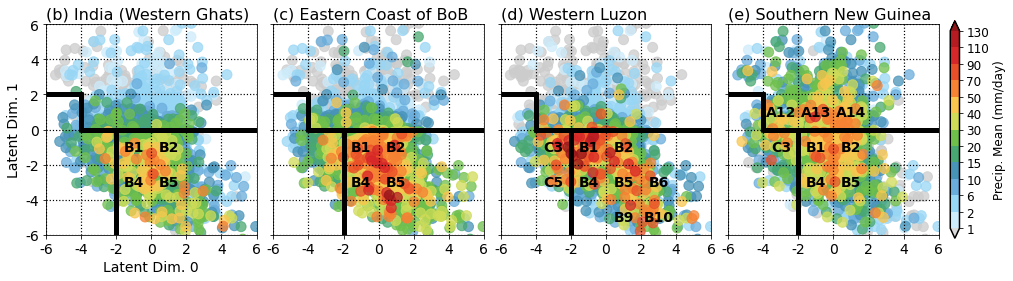

In [22]:
Plot_lv_regional_pcp(data_label='all', 
                     figtitle_dict={'title1':'India (Western Ghats)', 'title2':'Eastern Coast of BoB', 'title3':'Western Luzon', 'title4': 'Southern New Guinea'}, 
                     value_info='mean')

# Figure 8e–i: Upstream IVT analyses

In [23]:
def Plot_regional_polar(region:str, pcp_metrics:str, figtitle:str=False):
    # Figure initialization
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection':'polar'})
    ## Upstream polar with pcp
    pcp_region = pd.read_pickle(f'../../data/processed/weather_table_self/AAM_other_area/{region}_pcp_all_wattr.pkl')
    pcp_using  = pcp_region[pcp_metrics]
    upstream_region = np.load(f'../../data/processed/weather_table_self/AAM_other_area/{region}_upstream.npy', allow_pickle=True).item()
    IVT_theta  = np.asarray(upstream_region['theta'])
    IVT_r      = np.asarray(upstream_region['r'])
    
    temp = np.argsort(pcp_using)
    if pcp_metrics == 'mean':
        bounds_  = np.array([1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130])
        cmap_    = cmaps.WhiteBlueGreenYellowRed.copy()
        cmap_.set_under((0.8, 0.8, 0.8, 0.7))
        norm_    = colors.BoundaryNorm(bounds_, cmap_.N, extend='both')
    imscatter    = ax.scatter(IVT_theta[temp], IVT_r[temp], c=pcp_using.iloc[temp], s=120, alpha=0.65, cmap=cmap_, norm=norm_)
    util_draw_polar.draw_met_polar(ax)
    util_draw_polar.draw_met_polar_rticks(axe=ax, rmax=800, rmin=0, ticks=np.arange(200, 800.1, 200), ticklabels=[f"{int(i)}" for i in np.arange(200, 800.1, 200)])
    cax3         = fig.add_axes([ax.get_position().x1+0.025, ax.get_position().y0, 0.015, ax.get_position().height])
    cbar3        = fig.colorbar(imscatter, orientation='vertical', cax=cax3)
    cbar3.solids.set(alpha=1)
    cbar3.set_ticks(ticks=bounds_, labels=bounds_.astype(int))
    cbar3.ax.tick_params(labelsize=12)
    cbar3.set_label(f'Precip. {pcp_metrics.title()} (mm/day)', fontsize=12)
    cbar3.outline.set_linewidth(1.5)
    if figtitle: ax.set_title(figtitle, loc='left', fontsize=16)
    plt.show()

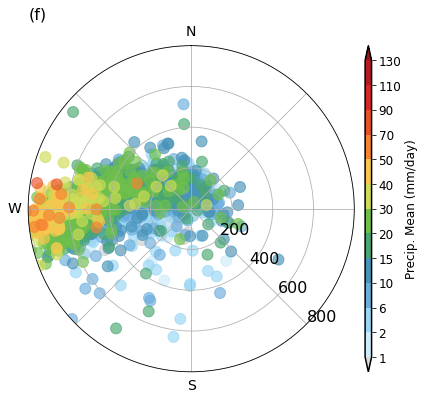

In [24]:
Plot_regional_polar(region='india', pcp_metrics='mean', figtitle='(f)')

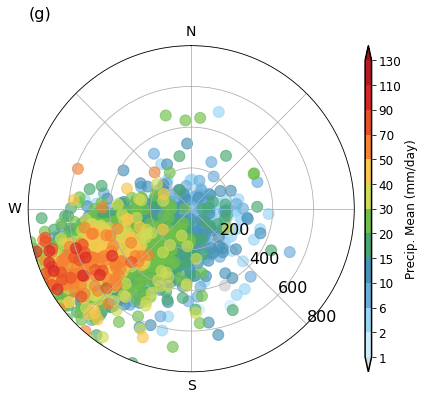

In [25]:
Plot_regional_polar(region='bob', pcp_metrics='mean', figtitle='(g)')

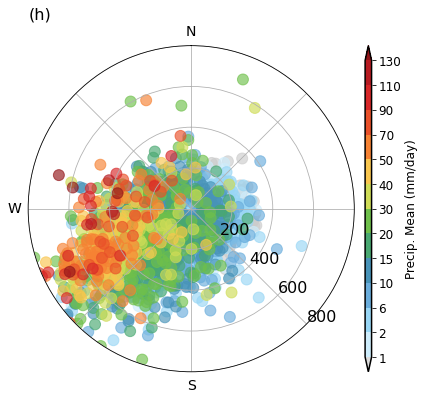

In [26]:
Plot_regional_polar(region='luzon', pcp_metrics='mean', figtitle='(h)')

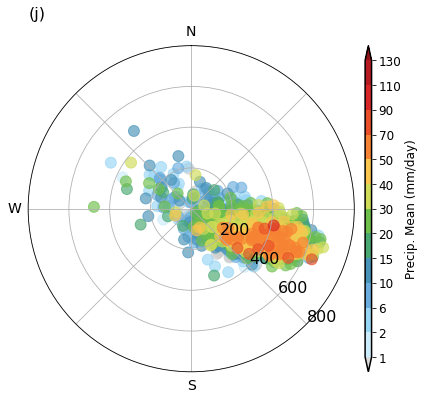

In [27]:
Plot_regional_polar(region='nguinea', pcp_metrics='mean', figtitle='(j)')